In [6]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import opendssdirect as dss
from utils import spectral_analysis
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens

In [3]:
sns.set_context("paper")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 1

## Data Management

In [4]:
def make_sens_ts(dvdp,dvdq,n=274):
    """Make timeseries of sensitivity matrices"""
    assert dvdp.shape[0] == dvdq.shape[0]
    m_tot = dvdp.shape[0] #total measurments
    m = int(m_tot/n) #Timeseries interval
    svp,svq = [],[] #timeseries list of svp and svq matrices
    for t in range(m):
        svp.append(dvdp[t*n:(t+1)*n,:])
        svq.append(dvdq[t*n:(t+1)*n,:])
    return {'svp':svp,
            'svq':svq}

def make_deviations(data):
    """Make finite differences"""
    p,q,v = data
    (dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
    dx = np.vstack((dp,dq))
    return (dx,dv)

def make_S_tilde(svp,svq):
    """Make wide S_tilde matrix"""
    return np.vstack((svp.T,svq.T)).T

def make_S_0(S_tilde,pct_obs):
    """Make initial observed matrix"""
    O,_ = constrained_linear_measurement_operator(S_tilde,pct_obs)
    O,S_0 = np.asarray(O),np.multiply(np.asarray(O),S_tilde)
    return O,S_0

In [5]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [ ]:
imp.reload(mat_sens)
pf = 0.9*np.ones(S_tilde.shape[0])
K = mat_sens.K(pf)
sqv_impl = [svq_t@K for svq_t in svq]
pct_obs = 0.2
S_tilde = make_S_tilde(svp[0],svq[0])
O,S_0 = make_S_0(S_tilde,pct_obs)


In [ ]:
imp.reload(mat_sens)
lambd_,delta1_,delta2_ = cp.Parameter(),cp.Parameter(),cp.Parameter()
lamb_.value,delta1_.value,delta2_.value = 1.25e-1,6e-2,8e-2
prob = mat_sens.mat_rec_problem_implicit(

In [8]:
pf = 0.9*np.ones(S_tilde.shape[0])
K = mat_sens.K(pf)
svq_impl = [svq_t@K for svq_t in svq]

In [460]:
dp,dq = dx[:int(len(dx)/2),:],dx[int(len(dx)/2):,:]
K_est = np.zeros_like(K)
for i,(dp_i,dq_i) in enumerate(zip(dp.T,dq.T)):
    DP = np.vstack((dp_i.T,np.ones_like(dp_i).T)).T
    lsq = np.linalg.inv(DP.T@DP)@DP.T@dq_i
    K_est[i,i] = lsq[0]

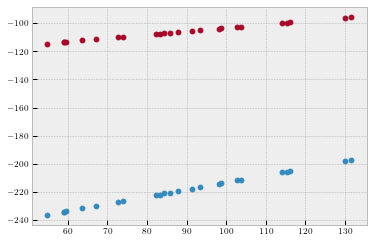

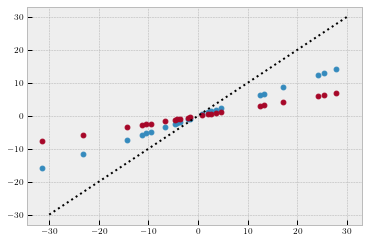

In [482]:

plt.plot(p[0,:],q[0,:],'o')
plt.plot(p[0,:],np.multiply(q[0,:],K[0,0]),'o',label='impl')
#plt.plot(np.linspace(-30,30),np.linspace(-30,30),'k:',label=r'$\Delta q_i=\Delta p_i$')
plt.figure()
plt.plot(dp[0,:],dq[0,:],'o')
plt.plot(dp[0,:],np.multiply(dq[0,:],-1*np.sign(q[0,:-1])*K[0,0]),'o',label='impl')
plt.plot(np.linspace(-30,30),np.linspace(-30,30),'k:',label=r'$\Delta q_i=\Delta p_i$')

In [458]:
print("Relative pct. error of the 'true' sensitivity matrix: ",np.linalg.norm(dv[:,0] - S_tilde@dx[:,0])/np.linalg.norm(dv[:,0])*100)

Relative pct. error of the 'true' sensitivity matrix:  1.1973718447073551


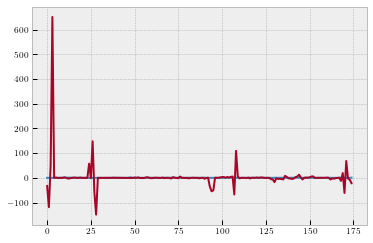

In [459]:
plt.plot(dp[:,0][25:200])
plt.plot((np.linalg.inv(svp[0])@dv[:,0])[25:200])

In [466]:
impl_err = []
hat_dq = np.zeros_like(dq)
for t,(dx_t,dv_t,svq_t,svp_t,q_t) in enumerate(zip(dx.T,dv.T,svq,svp,q.T)):
    #Split out dp_t and dq_t
    dp_t,dq_t = dx_t[:int(len(dx_t)/2)],dx_t[int(len(dx_t)/2):]
    #get signs of reactive power
    #sign_q = np.diag(np.sign(q_t))
    #svq_impl_t = svq_t @ (np.multiply(K,-sign_q))
    svq_impl_t = svq_t @K
    #make S_dagger
    S_dag = svp_t + svq_impl_t
    #Estimate dv_t,dp_t,dq_t
    hat_dv_t = S_dag@dp_t
    hat_dp_t = np.linalg.inv(svp_t)@dv_t
    hat_dq_t = (np.multiply(K,-sign_q))@dp_t
    hat_dq[:,t] = hat_dq_t
    #Construct hat_dx_t
    hat_dx_t = np.concatenate((hat_dp_t,hat_dq_t))
    impl_err.append({
        'dv_rel_err':utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100,
        'dp_rel_err':utils.calc_vector_rel_err(v_est=hat_dp_t,v_true=dp_t)*100,
        'dq_rel_err':utils.calc_vector_rel_err(v_est=hat_dq_t,v_true=dq_t)*100,
        'dx_rel_err':utils.calc_vector_rel_err(v_est=hat_dx_t,v_true=dx_t)*100
    })

import pandas as pd
df = pd.DataFrame.from_dict(impl_err)